In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
IMAGE_SIZE = [224, 224]

train_path = '/content/drive/MyDrive/cell_images/train'
valid_path = '/content/drive/MyDrive/cell_images/test'

In [10]:
vgg19 = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

80142336/80134624 [==============================] - 2s 0us/step


In [11]:
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [12]:
for layer in vgg19.layers:
    layer.trainable = False

In [13]:
x = Flatten()(vgg19.output)

In [14]:
prediction = Dense(2, activation='softmax')(x)

model = Model(inputs=vgg19.input, outputs=prediction)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [16]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [18]:
 training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/cell_images/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 416 images belonging to 2 classes.


In [19]:
training_set

In [20]:
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/cell_images/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 134 images belonging to 2 classes.


In [21]:
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
13/13 [==============================] - 20s 805ms/step - loss: 1.9617 - accuracy: 0.4792 - val_loss: 0.8362 - val_accuracy: 0.6791
Epoch 2/10
13/13 [==============================] - 9s 679ms/step - loss: 0.8575 - accuracy: 0.6154 - val_loss: 0.6885 - val_accuracy: 0.6418
Epoch 3/10
13/13 [==============================] - 9s 675ms/step - loss: 0.5209 - accuracy: 0.7399 - val_loss: 0.5708 - val_accuracy: 0.7015
Epoch 4/10
13/13 [==============================] - 9s 665ms/step - loss: 0.3730 - accuracy: 0.8335 - val_loss: 0.4664 - val_accuracy: 0.7164
Epoch 5/10
13/13 [==============================] - 9s 667ms/step - loss: 0.3333 - accuracy: 0.8785 - val_loss: 0.7251 - val_accuracy: 0.6418
Epoch 6/10
13/13 [==============================] - 9s 668ms/step - loss: 0.4027 - accuracy: 0.8065 - val_loss: 0.4064 - val_accuracy: 0.8060
Epoch 7/10
13/13 [==============================] - 9s 668ms/step - loss: 0.2808 - accuracy: 0.8942 - val_loss: 0.3805 - val_accuracy: 0.8358
Epoch

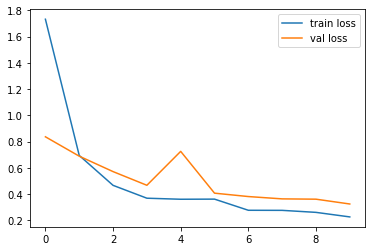

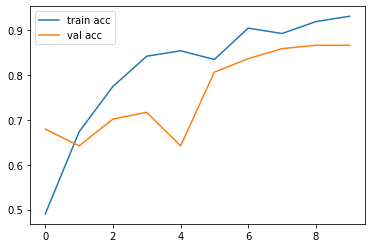

<Figure size 432x288 with 0 Axes>

In [23]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [24]:
from tensorflow.keras.models import load_model

model.save('model_vgg19.h5')

In [25]:
y_pred = model.predict(test_set)

In [26]:
y_pred

array([[7.3193240e-01, 2.6806754e-01],
       [9.6062028e-01, 3.9379735e-02],
       [9.9931896e-01, 6.8104838e-04],
       [2.4352694e-01, 7.5647300e-01],
       [8.9459580e-01, 1.0540417e-01],
       [3.2543290e-01, 6.7456710e-01],
       [5.8751655e-01, 4.1248351e-01],
       [2.3739763e-01, 7.6260239e-01],
       [7.9513371e-01, 2.0486630e-01],
       [9.8411012e-01, 1.5889822e-02],
       [7.9722077e-01, 2.0277926e-01],
       [9.8698968e-01, 1.3010272e-02],
       [9.8930770e-01, 1.0692356e-02],
       [3.9935604e-01, 6.0064399e-01],
       [6.1020494e-01, 3.8979504e-01],
       [7.5351775e-01, 2.4648224e-01],
       [9.8884028e-01, 1.1159757e-02],
       [8.2112855e-01, 1.7887145e-01],
       [9.9732167e-01, 2.6783207e-03],
       [9.1256911e-01, 8.7430939e-02],
       [9.7873789e-01, 2.1262063e-02],
       [5.1795745e-01, 4.8204252e-01],
       [8.5866171e-01, 1.4133824e-01],
       [2.2529171e-01, 7.7470827e-01],
       [2.9643476e-01, 7.0356518e-01],
       [8.6770171e-01, 1.

In [27]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [28]:
y_pred

array([0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0])

In [29]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [30]:
model=load_model('model_vgg19.h5')

In [31]:
img=image.load_img('/content/drive/MyDrive/cell_images/test/Uninfected/2.png',target_size=(224,224))

In [32]:
x=image.img_to_array(img)
x

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [33]:
x.shape

(224, 224, 3)

In [34]:
x=x/255

In [35]:
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [36]:
model.predict(img_data)

array([[0.07250041, 0.9274996 ]], dtype=float32)

In [37]:
a=np.argmax(model.predict(img_data), axis=1)

In [38]:
if(a==1):
    print("Uninfected")
else:
    print("Infected")

Uninfected
